In this study, I worked on making visual analystics based on public Seattle incident dataset .The dataset contains 610.590 incidents(observations) recorded in the city of Seattle since 1965. I used R and RMarkDown to generate this report. 

In [15]:
## Libraries Used
library(dplyr)
library(ggplot2)
library(caroline)
library(plotrix)
library(plotly)
library(repr)

## A Closer Look at Data
I have downloaded the data from Seattle Police Department web site. As shown in the following figure, the data includes crimes reported since 1965. However, there are relatively few incidents reported before 2008. Therefore, I decided to work on incidents occurred between 2008 and 2015.

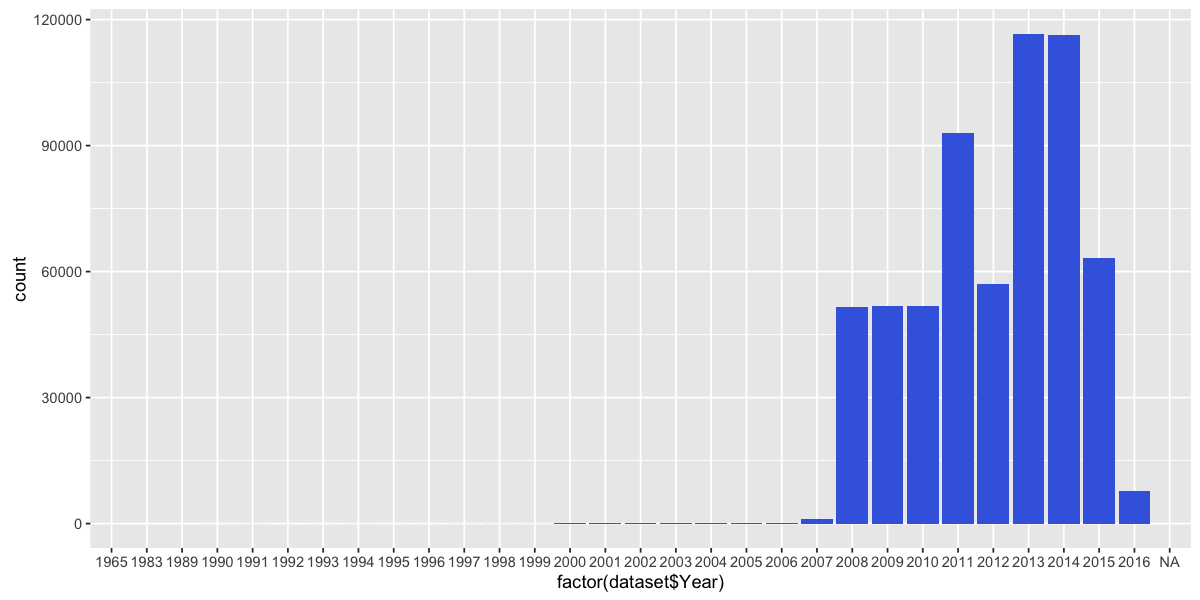

In [2]:
dataset <- read.csv(file="Seattle_Police_Department_Police_Report_Incident.csv",header=TRUE)
options(repr.plot.width=10,repr.plot.height=5)
ggplot(data=dataset,aes(x=factor(dataset$Year)))+geom_bar(stat = "count",fill="royalblue")

## Research Questions
In this study, I tried to find answers to the following questions:
How do incidents vary by year in the dataset?
What are the top-5 types of crime in the City of Seattle since 2008?
How do top-5 types of crimes vary by day of week?
How do top-5 types of crimes vary in 5 districts with hight crime rate for last 8 years?
Is there any increasing/decreasing trends in top-5 crimes?
What is the time of highest BURGLARY-FORCE-RES in District U?

# Data Munging
### Subsetting Data
Firstly, I subset the data to include incidents occurred in between 2008 and 2015. There are 601,107 observations recorded. There are 19 attributes/fields. Regarding the research questions, I figured out five important fields to work with: Offense Type,Occurred Date or Date Range Start, Location, Month, and Year. Also, there are 202 Offense Types observed in the data. Some of of them are listed below as an example.

In [3]:
mydata <- subset(dataset, dataset$Year>=2008 & dataset$Year<2016)
glimpse(mydata)
levels(mydata$Offense.Type)[1:10]

Observations: 601,107
Variables: 19
$ RMS.CDW.ID                        (int) 643613, 643233, 643259, 643306, 6...
$ General.Offense.Number            (dbl) 201658808, 201657602, 201657551, ...
$ Offense.Code                      (fctr) 5309, 2699, 2404, 2308, 2399, 23...
$ Offense.Code.Extension            (int) 0, 1, 1, 0, 3, 0, 48, 0, 0, 3, 0,...
$ Offense.Type                      (fctr) HARASSMENT, FRAUD-OTHER, VEH-THE...
$ Summary.Offense.Code              (fctr) 5300, 2600, 2400, 2300, 2300, 23...
$ Summarized.Offense.Description    (fctr) THREATS, FRAUD, VEHICLE THEFT, O...
$ Date.Reported                     (fctr) 02/18/2016 12:24:00 PM, 02/17/20...
$ Occurred.Date.or.Date.Range.Start (fctr) 01/01/2014 12:01:00 AM, 11/04/20...
$ Occurred.Date.Range.End           (fctr) , 11/28/2015 11:59:00 PM, 11/11/...
$ Hundred.Block.Location            (fctr) 8XX BLOCK OF VIRGINIA ST, 8XX BL...
$ District.Sector                   (fctr) D, K, O, L, R, W, N, D, C, M, S,...
$ Zone.Beat     

[1] "[INC - CASE DC USE ONLY]"   "ANIMAL-BITE"               
 [3] "ANIMAL-CRUELTY"             "ANIMAL-OTH"                
 [5] "ASSLT-AGG-BODYFORCE"        "ASSLT-AGG-GUN"             
 [7] "ASSLT-AGG-POLICE-BODYFORCE" "ASSLT-AGG-POLICE-GUN"      
 [9] "ASSLT-AGG-POLICE-WEAPON"    "ASSLT-AGG-WEAPON"

### Date Conversion
The date format of the data is not enough to do some critical analysis about the day of week, time of day. So, I made the necessary conversion as follows: The following is an example for the date format of an incident.

In [4]:
factor(mydata$Occurred.Date.or.Date.Range.Start[1])

[1] 01/01/2014 12:01:00 AM
Levels: 01/01/2014 12:01:00 AM

I need to retrieve the day of the week and the time of the day information from the given date format. I used POSIXct and POSIXlt function to convert between character representations and objects of classes representing calendar dates and times. I created two new fields, Hour and DayOfWeek, from Date field given in the data. Also, I created another field, MonthAbb for converting numeric Month value to name (ex: 2 -> feb.).

In [5]:
mydata$Occurred.Date.or.Date.Range.Start<-as.POSIXct(strptime(mydata$Occurred.Date.or.Date.Range.Start,"%m/%d/%Y %I:%M:%S %p"))
mydata$DayOfWeek <- as.factor(weekdays(mydata$Occurred.Date.or.Date.Range.Start))
mydata$Hour<-as.factor(as.POSIXlt(mydata$Occurred.Date.or.Date.Range.Start)$hour)
mydata <- transform(mydata, MonthAbb = month.abb[Month])
mydata$MonthAbb = factor(mydata$MonthAbb,levels=c("Jan","Feb","Mar", "Apr","May","Jun","Jul","Aug","Sep", "Oct","Nov","Dec"),ordered=TRUE)
mydata$DayOfWeek <- factor(mydata$DayOfWeek,levels=c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))

### Calculating the Counts
I am interested in the number of incidents (frequencies) by time of day, day of week, month of a year and a year. In order to calculate the frequencies, I created a new field, Count, and assign 1 as an initial value. Then I calculated the counts by Offense Type.

In [6]:
mydata$Count<-c(1)
counts <- aggregate(Count~Offense.Type,data=mydata,sum)

### Top-5 Crimes
There are 202 different Offense Types, and it is not possible to visualize all of them in one plot. Actually, you can do that but no one can understand anything. Therefore, I prefered to work with Top 5 crimes, and subset the data to keep data only for the following top-5 crimes.

In [7]:
offense_types_sorted <- counts$Offense.Type[order(-counts$Count)]
top_crime_types <- offense_types_sorted[1:5]
top_dataset <- subset(mydata, Offense.Type %in% top_crime_types)
top_crime_types

[1] THEFT-CARPROWL                 THEFT-OTH                     
[3] VEH-THEFT-AUTO                 PROPERTY DAMAGE-NON RESIDENTIA
[5] BURGLARY-FORCE-RES            
202 Levels: [INC - CASE DC USE ONLY] ANIMAL-BITE ANIMAL-CRUELTY ... WEAPON-UNLAWFUL USE

# Visualization on Data
## Research Question 1: How do incidents vary by year in the dataset?
To answer this question, I included all type of crimes reported in data. As you can see, the crime rate was very very high in 2013 and 2014 with respect to other years.

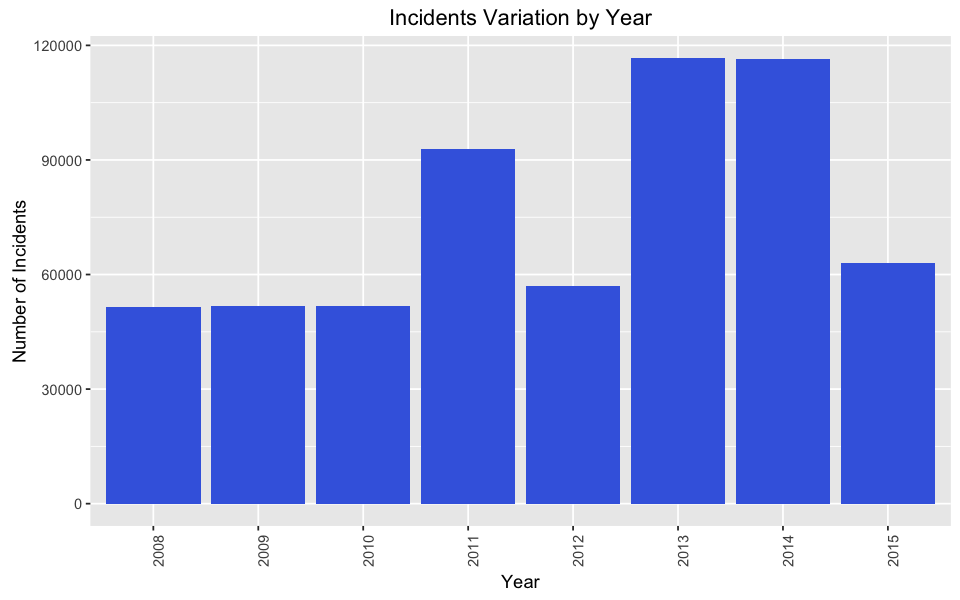

In [8]:
options(repr.plot.width=8,repr.plot.height=5)
ggplot(data=mydata,aes(x=factor(mydata$Year)))+labs(title="Incidents Variation by Year", x= "Year",y="Number of Incidents")+geom_bar(stat = "count",fill="royalblue")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Research Question 2: What are the top-5 types of crime in the City of Seattle since 2008?
Let's first look at the percentages of top-5 type of crimes. As shown in the following chart, THEFT-CARPOWL is the most common crime reported, which is 46 % of top-5 types of crime.

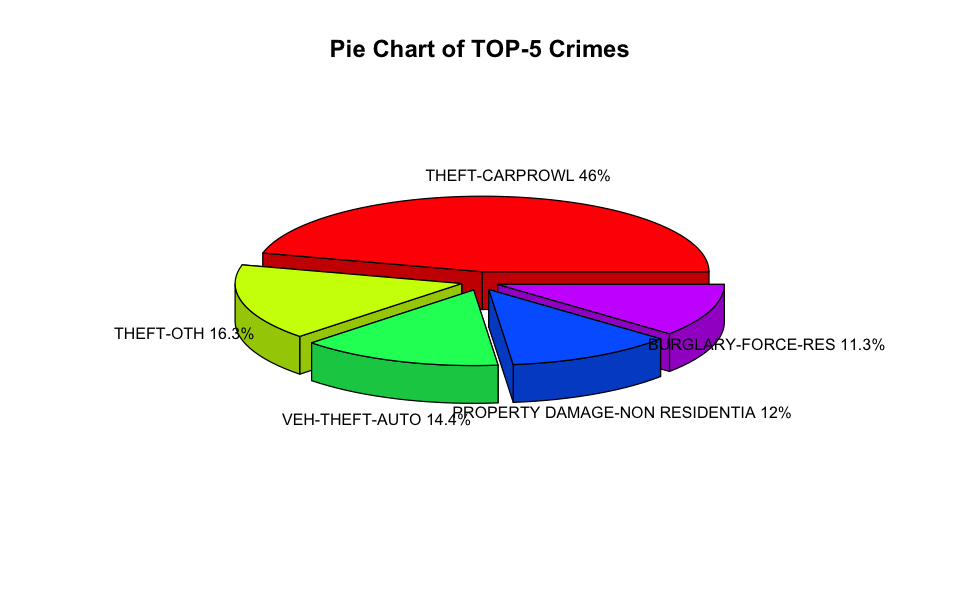

In [9]:
crimes_sorted <- counts[order(-counts$Count),]
top_crimes <- crimes_sorted[1:5,]
top5percentages <- pct(top_crimes,c("Count"))
pctlabels <- paste(round(top5percentages$Count.pct*100,digits=1),"%",sep="")
labels <- top5percentages$Offense.Type
labels <- paste(labels,pctlabels)
options(repr.plot.width=8,repr.plot.height=5)
pie3D(top5percentages$Count.pct,labels = labels,labelcex=0.8, explode=0.1, radius=1.2, col=rainbow(length(top5percentages$Count.pct)), main="Pie Chart of TOP-5 Crimes")

## Research Question 3: How do top-5 types of crimes vary by day of week?
In order to answer the research question, I needed to calculate the count values based on Offense.Type, Year and DayOfWeek. After having the count values, I created the following visualization. As you can see, BURGLARY-FORCE-RES has the same pattern for all last 6 years: it peaks on Friday and it gradually comes down and reaches its minimum on Sunday. It can also be seen that, THEFT-CARPOWL has a very high variation over the years and it is the most committed crime.

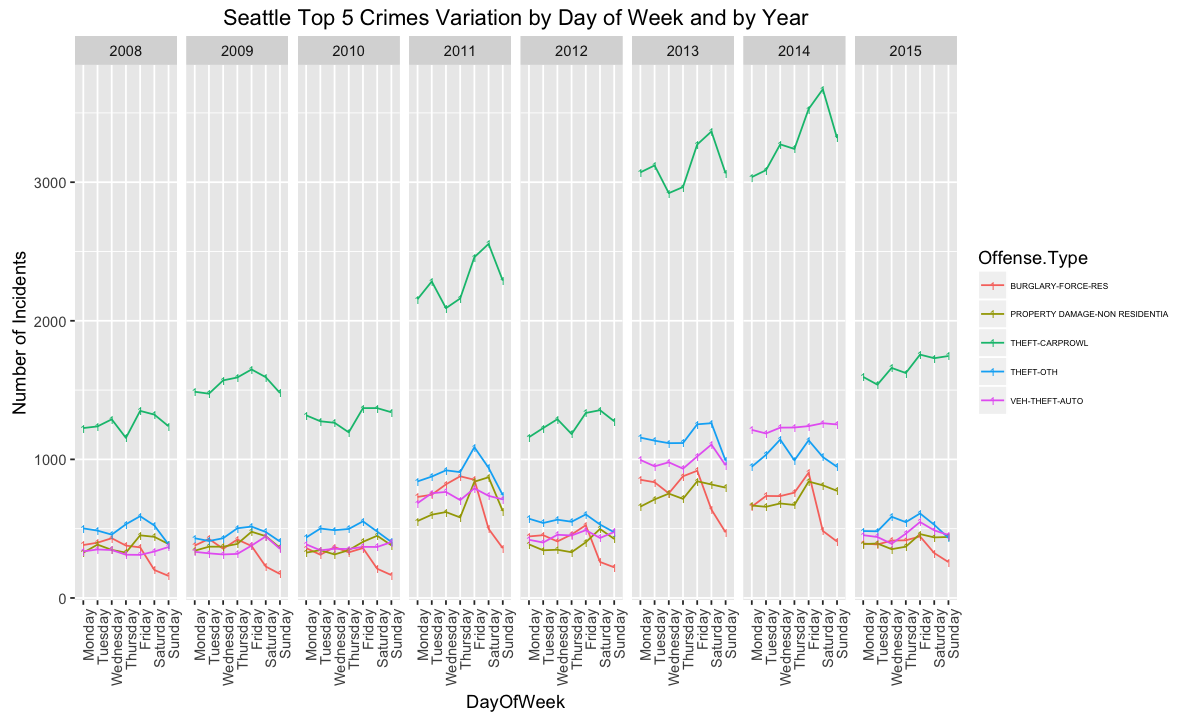

In [10]:
counts <- aggregate(Count~Offense.Type+DayOfWeek+Year,data=mydata,sum)
top_dataset <- subset(counts, Offense.Type %in% top_crime_types)
top_dataset$DayOfWeek <- factor(top_dataset$DayOfWeek,levels=c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))
options(repr.plot.width=10,repr.plot.height=6)
ggplot(data=top_dataset,aes(DayOfWeek,Count))+labs(title="Seattle Top 5 Crimes Variation by Day of Week and by Year",y="Number of Incidents")+facet_grid(~Year)+theme(legend.text = element_text(size = 5))+geom_line(aes(colour=Offense.Type,group=Offense.Type))+geom_point(shape="18",aes(colour=Offense.Type),size=2)+theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Research Question 4: How do top-5 types of crimes vary in 5 districts with hight crime rate for last 8 years?
In order to answer this question, I figured out the districts with hight crime rate. I found "M", "K", "D", "U" and "E" are the first five districts with high crime rate.

In [11]:
count_values_district <- aggregate(Count~District.Sector,data=mydata,sum)
districts_sorted <- count_values_district[order(-count_values_district$Count),]
district_names <- count_values_district$District.Sector[order(-count_values_district$Count)]
high_crime_rate_districts <- district_names[1:5]
high_crime_rate_districts

[1] M K D U E
Levels:  99 B C D E F G H J K L M N O Q R S U W

Then I calculated the frequencies of top-5 crimes in 5 districts for last 8 years. The plot reveals the following:
* THEFT-CARPROWL is at maximum in all 5 districts in 2014
* THEFT-CARPROWL is the most committed crime in all 5 districts in all years
* THEFT-OTH is at maximum in all 5 districts in 2013
* District K and Districk M are similar districts with respect to top-5 crime distribution
* BURGLARY-FORCE-RES crime rate is very low compared to other crimes in almost all districts except district U, where that crime rate is also high

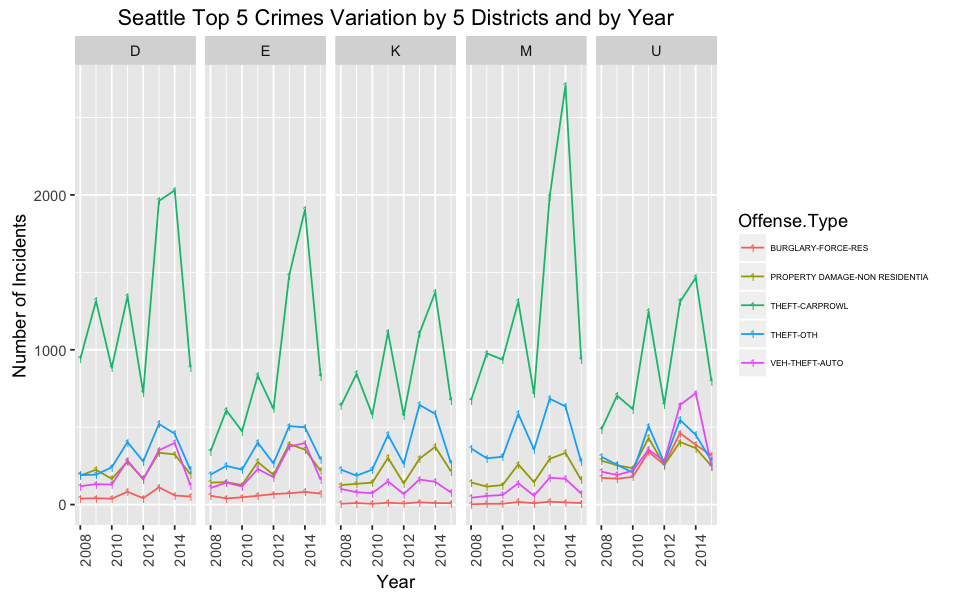

In [12]:
count_district_year <- aggregate(Count~Offense.Type+District.Sector+Year,data=mydata,sum)
top_districts <- subset(count_district_year, Offense.Type %in% top_crime_types & District.Sector %in% high_crime_rate_districts)
options(repr.plot.width=8,repr.plot.height=5)
ggplot(data=top_districts,aes(Year,Count))+labs(title="Seattle Top 5 Crimes Variation by 5 Districts and by Year",y="Number of Incidents")+facet_grid(~District.Sector)+theme(legend.text = element_text(size = 5))+geom_line(aes(colour=Offense.Type,group=Offense.Type))+geom_point(shape="18",aes(colour=Offense.Type),size=2)+theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Research Question 5: Is there any increasing/decreasing trends in top-5 crimes?
It is pretty obvious that THEFT-CARPROWL crime rate tends to increase in all districts.

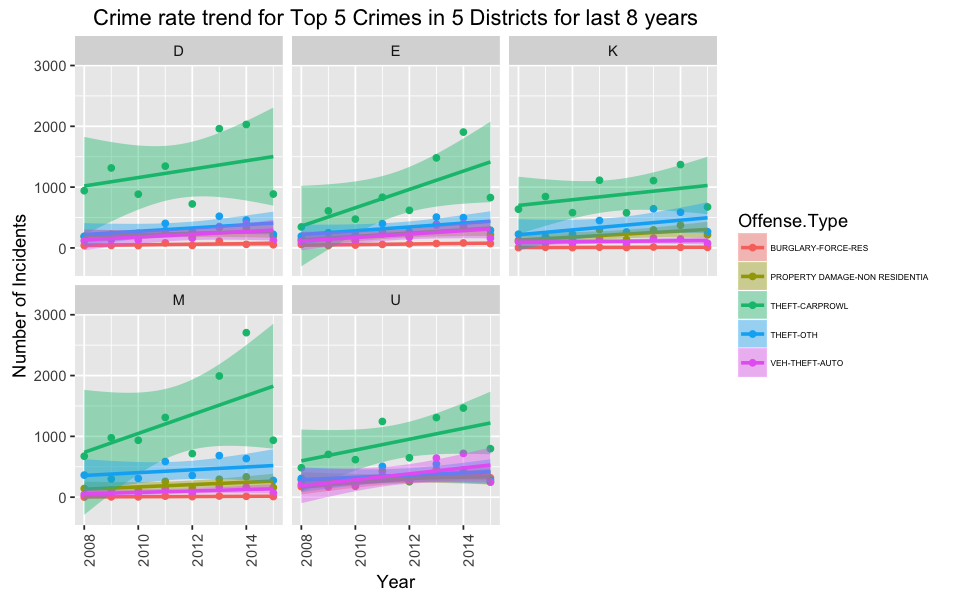

In [13]:
ggplot(data=top_districts,aes(Year,Count))+labs(title="Crime rate trend for Top 5 Crimes in 5 Districts for last 8 years",y="Number of Incidents")+facet_wrap(~District.Sector)+theme(legend.text = element_text(size = 5))+geom_point(aes(colour=Offense.Type))+theme(axis.text.x = element_text(angle = 90, hjust = 1))+geom_smooth(method="lm",se=TRUE,aes(fill=Offense.Type, color=Offense.Type))

## Research Question 6: What is the time of highest BURGLARY-FORCE-RES in District U?
In the previous analysis, we figured out that BURGLARY-FORCE-RES crime has different pattern in District U. The following plot reveals that, BURGLARY-FORCE-RES crime increases sharply after 6:00 am and decreases after 18:00 pm.

In [16]:
burglaryInU <- mydata[mydata$Offense.Type=="BURGLARY-FORCE-RES" & mydata$District.Sector=="U",]
count_hour <- aggregate(Count~Hour+Offense.Type,data=burglaryInU,sum)
p <- plot_ly(count_hour, x = Hour, y = Count, name = "BURGLARY-FORCE-RES Variation by Time of Day in District U")  
p <- layout(p,title = 'high BURGLARY-FORCE-RES crime rate', 
             shapes = list(
               list(type = "rect", 
                    fillcolor = "blue", line = list(color = "blue"), opacity = 0.3, 
                    x0 = "6", x1 = "18", xref = "x", 
                    y0 = 0, y1 = 170, yref = "y")
))
embed_notebook(p)